###**Andrew Renninger**
### Homework Four

In [0]:
!pip install tifffile
!pip install rasterio

##Libraries

In [0]:
import sys
import os
import json 

from google.colab import drive

import numpy as np
import pandas as pd

from skimage.transform import resize
from skimage.color import rgb2gray

import matplotlib
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn.svm import SVC
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

from sklearn.utils import shuffle

##Directory

In [3]:
drive.mount('/content/drive')

directory = '/content/drive/My Drive/shipsnet'
kaggle = directory + '/shipsnet.json'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#S1:
Check the description, data, activities and scripts. HW4 will use the "Ships" dataset. Download the data to your PC/laptop (data size 434 MB). The data is kept in .json format and reading it in Python is pretty straightforward. See example notebooks.

- Q1: What is the number of images in this dataset: **4000**
- Q2: What is the number of different labels in this dataset: **2 different labels**
- Q3: What is the size of each image in this dataset: **80 x 80 x 3 bands**

In [4]:
with open(kaggle) as ships:
    shipsnet = json.load(ships)

df = pd.DataFrame(shipsnet)
df.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


First, we just see what we are working with by importing the data and showing the first rows of it as a data frame. The latitude and longitude mean that we can plot where each image was captured. 

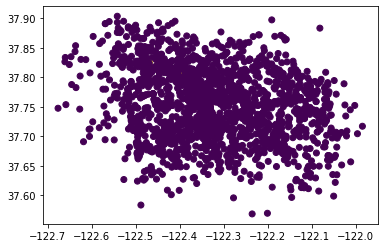

In [5]:
lon,lat = [],[]

for i,j in df['locations']:
    lon.append(i)
    lat.append(j)

lon = np.array(lon)
lat = np.array(lat)

lab = df['labels']
col = lab[(lon < -120) & (lat > 37)]

plt.scatter(lon[lon < -120], lat[lat > 37], c = col)

Now we can get into the machine learning by setting the target labels as y and the raster data (which is flat) as X. Because it is flat, we need to reshape it and move the axis—for some reason it is 3 by 80 by 80 instead of what you might expect, with the shape of the image first and then bands layered from there—so we reshape it. 

In [6]:
y = np.asarray(shipsnet['labels'])
X = np.asarray(shipsnet['data']).astype('uint8')

print(y.shape)
print(X.shape)

(4000,)
(4000, 19200)



#S2:
Select all "ship" images, convert 3-channel (RGB) images to single-channel (Gray) (hint: scikit has the function "rgb2gray"). Flatten the images into a data matrix and apply PCA on them. Display the first 4 principal components as 2D images.

- Q1: What is the number of "ship" images: **1000**
- Q2: What is the total variance explained by the first 5 PCA components: **0.7333**
- Q3: How many PCA components are required to explain at least 50% of the variance: **just two components!**

In [7]:
reshaped = X.reshape([4000, 3, 80, 80])
reaxised = np.moveaxis(reshaped, 1, 3)

bnw = rgb2gray(reaxised)
col = reaxised
dat = bnw.reshape([4000, 6400])

print(bnw.shape)
print(col.shape)
print(dat.shape)

(4000, 80, 80)
(4000, 80, 80, 3)
(4000, 6400)


Because we made a few transformations, we will start by plotting a sample to get a feel for this format and to check the shape of the data.

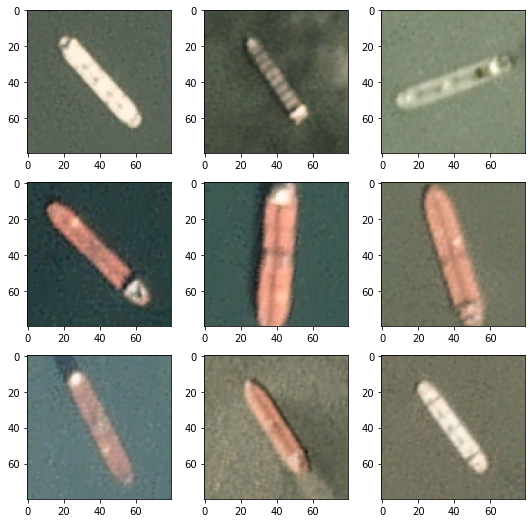

In [8]:
fig, axs = plt.subplots(3, 3, figsize = [9, 9])

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
        idx = i*5+j
        cImg = col[idx]
        axs[i, j].imshow(cImg)
        
plt.show()

Then we plot the greyscale version of the same images to make sure that that worked.

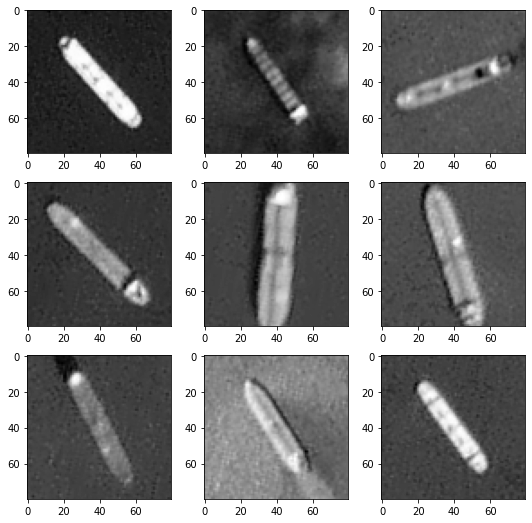

In [9]:
fig, axs = plt.subplots(3, 3, figsize = [9, 9])

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
        idx = i*5+j
        gImg = bnw[idx]
        axs[i, j].imshow(gImg, cmap = 'gray')
        
plt.show()

Next, we take a random selection just to see if everything is as it should be, with flattened images that can be reshaped into the original tile.

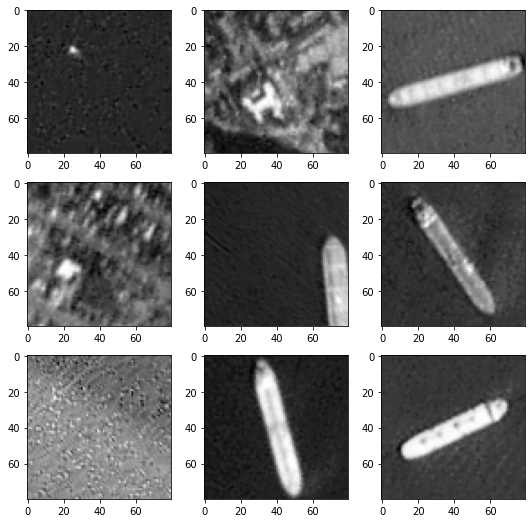

In [10]:
sel = np.random.randint(0, 4000, 9)

fig, axs = plt.subplots(3, 3, figsize = [9, 9])

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
        idx = i*3+j
        gImg = dat[sel[idx]].reshape([80, 80])
        axs[i, j].imshow(gImg, cmap = 'gray')
        
plt.show()

Because ships are denoted with a 1, we can count the number of them. 


In [11]:
print(len(y[y == 1]))

1000


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

The number of components right now is arbitray, but we can come back to that later.

In [0]:
NUM_COMP = 80

The first section requires us to look at ship images, so we filter for that and then go into PCA. 

In [0]:
mat = dat[y == 1]

scaler = StandardScaler()
scaler.fit(mat)
X = scaler.transform(mat)

In [15]:
pca = PCA(n_components = NUM_COMP)
pcaMdl = pca.fit(X)
pcaCoor = pcaMdl.transform(X)
dfPCA = pd.DataFrame(data = pcaCoor, columns = ['PCA_' + s for s in np.arange(0, NUM_COMP).astype(str)])

dfPCA.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27,PCA_28,PCA_29,PCA_30,PCA_31,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50,PCA_51,PCA_52,PCA_53,PCA_54,PCA_55,PCA_56,PCA_57,PCA_58,PCA_59,PCA_60,PCA_61,PCA_62,PCA_63,PCA_64,PCA_65,PCA_66,PCA_67,PCA_68,PCA_69,PCA_70,PCA_71,PCA_72,PCA_73,PCA_74,PCA_75,PCA_76,PCA_77,PCA_78,PCA_79
0,-14.077932,-16.978053,-33.529743,11.573296,18.720670,11.260411,9.582690,-8.038178,-9.054114,5.382610,-7.420555,10.487580,-8.769588,-6.030578,-1.769539,1.805166,8.260207,5.631623,-1.275234,7.402271,2.916972,-0.018775,-5.499016,2.538269,0.130324,-1.319499,-2.721544,-1.712954,2.128888,-1.765789,-4.857680,1.257454,-0.739240,-1.161754,-2.758009,-0.795118,-1.731470,-0.268137,-2.369297,1.012688,0.582739,-2.916213,0.741884,-1.495468,-0.736206,-0.600617,0.719801,-0.187682,-1.493401,-0.336751,2.018995,-1.230780,-1.071494,-0.653281,-1.264958,0.946340,-0.005264,1.018368,0.811565,0.953266,-0.438571,0.291801,2.811561,-0.026740,0.185061,-2.208093,-0.293610,0.594125,-0.658443,0.368813,-0.632009,-1.387291,1.791271,-0.931949,-0.387092,-1.138580,1.245690,0.580561,0.982106,1.021395
1,32.017468,10.177297,-12.653708,-12.580257,-8.679751,-16.532534,3.406943,1.826551,-11.611023,12.233846,-2.870245,4.141836,-4.877332,0.797240,-3.775325,2.186594,1.879907,2.060122,-8.775889,-7.939076,-0.443255,-5.282829,0.422822,-1.702424,3.327998,2.008490,-0.708213,-0.237270,-0.360950,-2.331215,-2.526909,-7.028450,4.178043,7.107188,7.679564,-4.485455,-2.158902,0.367105,0.900817,-3.333761,-5.423837,-0.332967,2.241673,3.486344,-0.400212,-1.102594,-3.339701,-1.164228,-0.399193,-3.204560,1.811090,-1.659742,-2.874005,0.250602,-1.105405,7.672984,1.462635,-0.225806,0.785773,-0.672447,1.018471,1.364112,-2.724682,3.582224,-3.038974,-0.552664,0.887509,-1.636102,0.346537,-0.247434,1.400001,-2.415513,-0.543042,1.325495,-2.566920,0.289019,-1.210615,-1.494719,0.757100,-2.277918
2,-107.982785,14.046083,-2.876603,2.634877,-8.172656,-0.085015,4.347316,3.990251,2.700569,-1.398098,-4.274600,-2.245934,4.731859,-5.602416,-3.209090,1.498545,-1.579164,1.038782,7.153275,-0.355284,0.665318,-2.019304,0.467248,2.253273,-3.210312,-1.995969,-3.242703,-1.830086,3.064104,0.209613,0.802868,0.560246,-0.733503,2.304753,-0.639432,-0.775030,2.221067,0.631404,2.495044,-0.707168,0.654842,2.096568,0.031459,-1.029938,0.168422,0.156919,0.786435,-1.266615,-0.751282,0.555934,0.538899,-0.626680,0.269030,1.124627,-0.143387,-0.414066,-2.057014,-0.763600,-0.379655,0.564491,2.091316,-1.355408,-0.170765,1.747064,3.282734,-0.000551,-0.885786,-1.232252,-1.164187,0.876711,0.255357,0.416117,-0.049451,0.730707,2.322148,0.572436,-0.289976,1.180699,1.201644,-0.761627
3,-27.606383,-3.132887,-23.871521,-6.986916,10.762392,2.359888,6.640722,-13.488102,1.596914,-10.714499,-8.406881,-0.138201,-1.716702,2.386171,13.019942,-2.218242,0.970357,-2.201122,-0.981846,-5.371105,-11.210856,3.935375,0.296625,0.427310,2.994848,-5.007830,1.878613,-6.835483,2.498635,3.419738,1.783443,0.620456,2.747036,0.428749,2.499417,-7.092156,-0.387320,1.136054,5.549170,-2.639796,1.049436,-0.386586,0.452827,-0.805168,-3.088856,-0.042137,-1.269106,5.449270,2.468295,-1.753787,-0.610486,-2.783354,0.718706,-0.211666,1.139033,-3.390707,0.554677,-0.780078,1.494159,0.770393,-0.707378,1.328236,-0.737799,1.678559,-2.552788,1.770335,1.935780,-2.481893,-0.993484,3.128439,2.212233,0.653234,-4.312015,0.087929,1.481768,2.270914,-1.853507,-1.190806,-1.182686,-0.460204
4,-18.135146,38.486120,1.566045,16.395782,-3.952323,-0.742642,2.611646,-6.817596,1.408903,10.304429,-6.911902,-1.503573,10.761035,5.225606,-7.818865,-2.543319,6.457763,0.287172,15.787709,10.723525,-4.513485,7.594362,0.876195,-0.362264,5.078585,-3.625434,3.324804,3.095251,-2.031155,-4.679833,-2.804775,-5.036176,2.012588,0.170563,7.338361,-0.986076,2.154808,-0.826535

In [16]:
print(np.sum(pcaMdl.explained_variance_ratio_[:4]))
print(np.sum(pcaMdl.explained_variance_ratio_[:1]))

0.7333016283710195
0.5726031045649539


In [17]:
print(np.sum(pcaMdl.explained_variance_ratio_))

0.9482848175001222


Then we can plot the components, which very much match the contours of ships at different angles. 

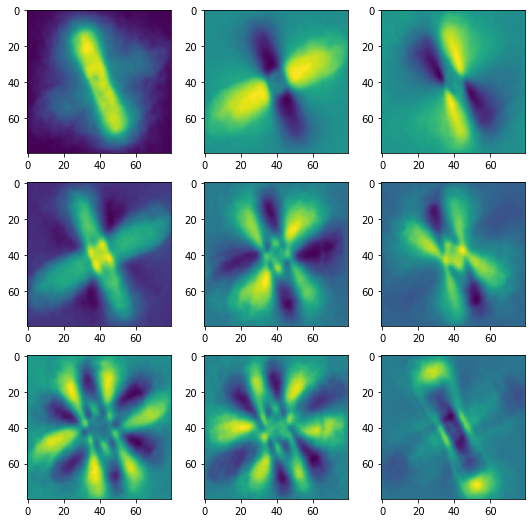

In [18]:
size = bnw[1,:,:].shape

fig, axs = plt.subplots(3, 3, figsize = [9, 9])

for i in np.arange(0,3):
    for j in np.arange(0,3):
        idx = i*3+j
        img = np.array(pcaMdl.components_[idx,:]).reshape(size)
        axs[i,j].imshow(img)
        
plt.show()

#S3:
Select all images, convert 3-channel (RGB) images to single-channel (Gray) (hint: scikit has the function "rgb2gray"). Flatten the images into a data matrix and apply PCA on them. Display the first 4 principal components as 2D images

- Q1: What is the total variance explained by the first 5 PCA components: **0.6086**
- Q2: How many PCA components are required to explain at least 50% of the variance: **just three components**
- Q3: Comment on the differences in variance explained in comparison to S2: 

**It is rather expected that images with and without ships would be more varied compared scenes capturing ships and only ships; likewise, fewer components explain more variation in the partial subset compared to the complete set. Also compelling is the nature of components when plotted: because ships—at least container ships—are all similar in shape, the only variation appears to be in the angle of that shape, so the plots end up looking like a clock in the first round. Perhaps the varation in the second round leads to blurred boundaries—though it is interesting that even in the larger sample, the contours of ships still pop out, suggesting that most distinctive aspect of all images in the presence or absence of a container ship.** 

In [0]:
mat = dat

scaler = StandardScaler()
scaler.fit(mat)
X = scaler.transform(mat)

In [20]:
pca = PCA(n_components = NUM_COMP)
pcaMdl = pca.fit(X)
pcaCoor = pcaMdl.transform(X)
dfPCA = pd.DataFrame(data = pcaCoor, columns = ['PCA_' + s for s in np.arange(0, NUM_COMP).astype(str)])

dfPCA.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27,PCA_28,PCA_29,PCA_30,PCA_31,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50,PCA_51,PCA_52,PCA_53,PCA_54,PCA_55,PCA_56,PCA_57,PCA_58,PCA_59,PCA_60,PCA_61,PCA_62,PCA_63,PCA_64,PCA_65,PCA_66,PCA_67,PCA_68,PCA_69,PCA_70,PCA_71,PCA_72,PCA_73,PCA_74,PCA_75,PCA_76,PCA_77,PCA_78,PCA_79
0,2.148901,30.585231,-6.872858,-17.615758,9.905715,28.423230,-1.891846,-23.514001,-5.355434,12.838623,4.713343,-4.512765,-3.671243,-4.969569,-0.392629,1.628276,12.850397,-0.354129,7.595722,-4.309164,-9.171653,-2.257056,-3.245795,1.901859,-0.934382,4.918159,-10.762427,-1.300498,1.358884,2.729666,-3.776479,0.473522,-6.506432,3.163578,1.248050,5.765058,0.407196,3.290786,1.847009,4.669582,-3.633565,1.425156,0.020934,-0.062916,2.316076,2.497313,2.557156,-4.895472,-1.162880,-4.389805,0.034331,1.346512,1.208643,2.950112,2.539220,-3.758731,-1.446019,-0.186896,-1.347118,-1.829417,-0.176569,-1.906162,-0.226530,-1.298728,1.020509,2.647513,0.598696,-0.688585,-0.336532,-3.967038,1.452736,1.518456,2.256030,-2.046167,-1.888605,-0.114072,1.692396,-1.047707,-0.437904,0.499006
1,-44.844173,-4.885748,7.011732,-8.592884,0.388665,9.426010,-14.106101,-1.422176,5.050704,6.357340,-0.800335,-4.316602,-4.801843,5.164651,3.294718,5.400480,10.409945,-0.039407,-4.179049,-2.791163,-2.320531,-3.832037,-1.885214,0.327017,-1.794180,0.315252,0.824452,-3.501485,-1.179694,-0.624599,-0.418227,-1.530689,-3.313189,5.038436,4.155861,-2.626719,2.283999,-0.360241,0.242321,0.670557,-0.981125,-1.568366,4.878768,-1.381910,-3.691661,-1.497105,3.858757,-3.003088,0.420558,-2.895620,2.215768,-3.119858,2.126413,1.544913,-0.917110,-2.214467,-2.915761,-0.963951,-1.070184,3.715998,-3.559635,0.067693,2.437442,-2.187569,-2.185041,-0.249751,0.269489,-1.776141,-1.226606,1.048939,1.004924,-0.035388,0.832987,-0.961549,-0.970614,-1.908952,-1.875823,-0.559771,-0.073364,0.160836
2,70.373457,-3.163573,1.826252,8.435343,2.244189,10.296961,0.157574,4.265899,3.703930,-4.148793,0.658921,-2.303873,8.220679,0.574567,-0.187030,-4.012184,1.277928,-4.489516,2.627794,1.885613,1.544818,-0.856274,-2.053239,1.904015,2.167312,-5.012373,-1.853613,-1.769694,2.793488,-0.681949,-0.792062,1.618876,-3.914606,-0.131095,-0.721022,2.767859,-1.602645,-2.571503,-3.253325,0.883415,-0.122112,1.521191,-1.314635,1.232968,0.681641,1.549025,-1.017029,-0.754401,-0.723724,-1.296009,0.252754,-1.508189,-1.836633,0.450908,3.293390,-0.212286,-1.691098,-0.842572,-0.192936,3.664103,2.491081,1.444947,-2.010970,2.731315,-2.006326,-3.142872,-2.545419,0.803433,-0.051373,1.142033,2.402983,-1.201054,1.092838,0.246676,1.493594,-2.150036,-0.827734,-2.203363,-0.209901,-0.222039
3,7.693515,4.942821,-7.429404,-13.403251,1.715132,16.506608,2.447222,-15.303728,-5.964783,3.321235,4.024932,-2.417283,-0.993675,-6.011931,-2.056555,1.466565,4.618395,2.352577,11.700064,-2.481631,-2.613435,3.984337,3.473472,7.969621,-0.054627,-5.514687,0.657507,-0.792044,0.342054,5.841637,-4.358471,-4.695530,-0.226669,2.754015,-4.048872,1.966782,2.189438,0.791858,5.551071,3.421719,3.903032,3.944482,0.567930,-1.293913,-0.053235,-0.425287,0.965382,-0.819064,1.345827,1.308565,-1.118579,4.074732,-1.682498,-4.309098,-0.295988,-3.566313,1.452029,-1.271338,2.775038,0.333838,3.327995,-3.207317,0.894888,0.319679,2.059804,-3.584914,1.877932,0.841531,3.947199,1.695751,-0.572999,4.381159,-2.979547,1.025687,2.190024,-0.685950,1.452390,-0.837636,2.304323,0.159494
4,-0.099001,-1.200788,13.657038,26.789237,20.645788,15.035935,-3.540578,3.848846,3.319207,-13.422231,-1.633091,-7.561528,5.040490,0.003990,-0.625978,-2.405072,1.137052,-2.050505,8.079095,-3.657230,-1.702632,-4.301674,-1.204682,-0.566818,6.090822,-5.741062,0.368301,0.391444,-3.147030,-3.311912,1.082456,-1.572814,-2.205845,-2.841885,2.192172,-0.663455,-4.346066,-0.023022,-5.34883

In [21]:
print(np.sum(pcaMdl.explained_variance_ratio_[:4]))
print(np.sum(pcaMdl.explained_variance_ratio_[:2]))

0.6086453174840386
0.548476041993654


In [22]:
print(np.sum(pcaMdl.explained_variance_ratio_))

0.8859535079932164


The plots below show that with more images in the sample, we see less definition in the sample and more variation. 

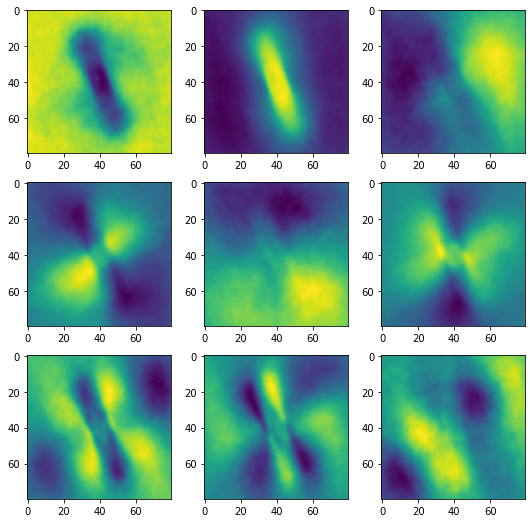

In [23]:
size = bnw[1,:,:].shape

fig, axs = plt.subplots(3, 3, figsize = [9, 9])

for i in np.arange(0,3):
    for j in np.arange(0,3):
        idx = i*3+j
        img = np.array(pcaMdl.components_[idx,:]).reshape(size)
        axs[i,j].imshow(img)
        
plt.show()

#S4:
Apply k-means clustering on all "ship" images for 4 clusters. Calculate the "mean" image for each cluster and display it.

- Q1: Comment on the clusters detected. Is there a common pattern for each cluster? Are the ships grouped based on orientation, image intensity differences, or something else?

**The clusters appear to be picking up most on the orientation of the ships and the lightness of the containers and the darkness of the sea. This is not perfect, though, and there appear to be many acceptions.**

In [0]:
from sklearn.cluster import KMeans

The question did not specify, so we use the components, rather than the raw data here to save time—though this will likely weaken any cluster analysis.

In [0]:
filteredPCA = pcaCoor[y == 1]
filteredDAT = dat[y == 1]

vals = KMeans(n_clusters = 4, random_state = 0).fit(filteredPCA)

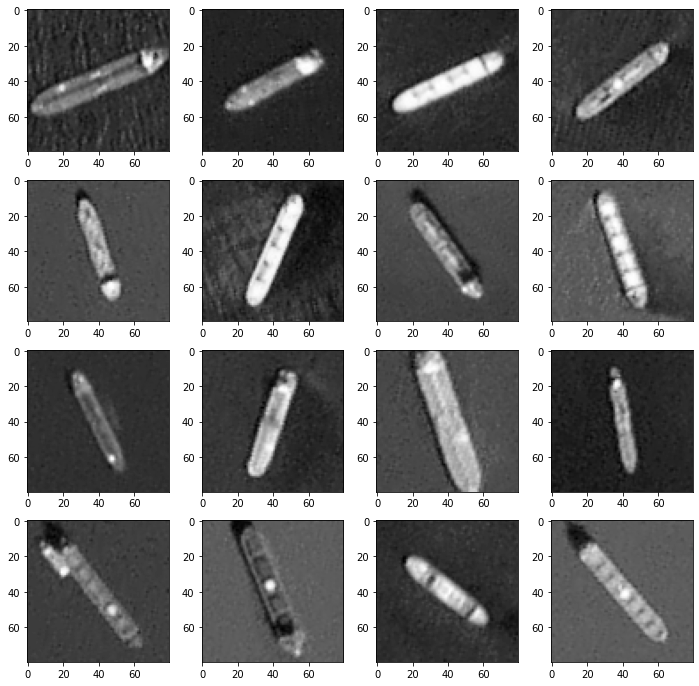

In [26]:
size = bnw[1,:,:].shape

fig, axs = plt.subplots(4, 4, figsize = [12, 12])

for i in np.arange(0, 4):
  sub = filteredDAT[vals.labels_ == i]
  for j in np.arange(0, 4):
    idx = np.random.randint(0, len(sub))
    img = sub[idx].reshape([80, 80])
    axs[i, j].imshow(img, cmap = 'gray')
        
plt.show()

The mean image is relatively easy to calculate and shows that clusters in a way mirror components. 

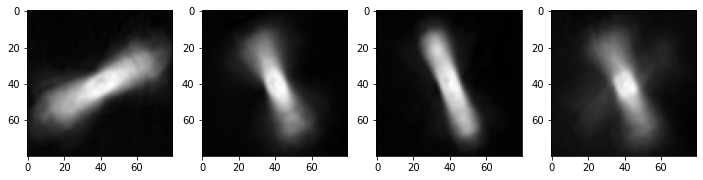

In [27]:
size = bnw[1,:,:].shape

fig, axs = plt.subplots(1, 4, figsize = [12, 12])

for i in np.arange(0, 4):
  sub = filteredDAT[vals.labels_ == i]
  img = np.mean(sub, axis = 0).reshape([80, 80])
  axs[i].imshow(img, cmap = 'gray')
        
plt.show()

#S5:
Apply k-means clustering on all images for 2 clusters.

- Q1: Calculate the "accuracy" of your clustering to discriminate ships from non-ship images. Show a two-by-two confusion matrix (to display the number/percentage of samples in clusters 1/2 and with labels 0/1)

**Conditional on which cluster we decide is classifying ships, the accuracy is either 46.375 or 53.625, so hardly better than chance in the best case.**

In [0]:
vals = KMeans(n_clusters = 2, random_state = 0).fit(pcaCoor)

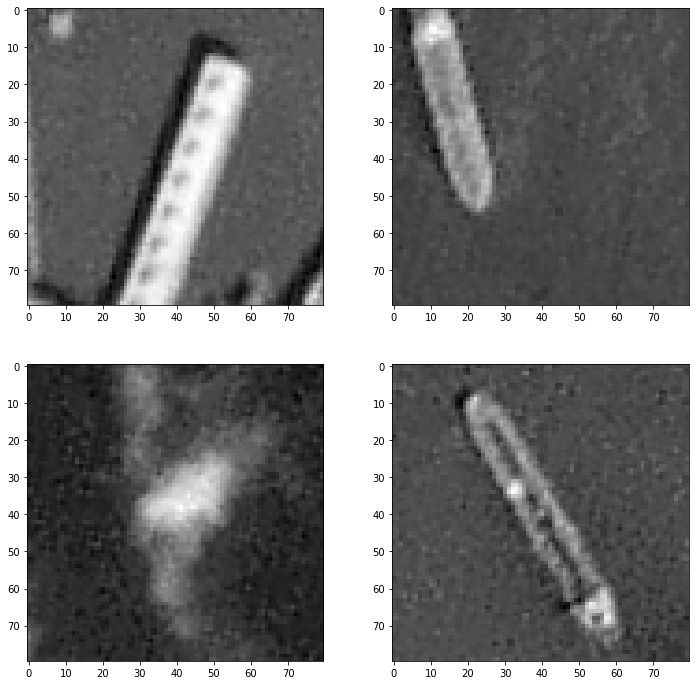

In [29]:
size = bnw[1,:,:].shape

fig, axs = plt.subplots(2, 2, figsize = [12, 12])

for i in np.arange(0, 2):
  sub = dat[vals.labels_ == i]
  for j in np.arange(0, 2):
    idx = np.random.randint(0, len(sub))
    img = sub[idx].reshape([80, 80])
    axs[i, j].imshow(img, cmap = 'gray')
        
plt.show()

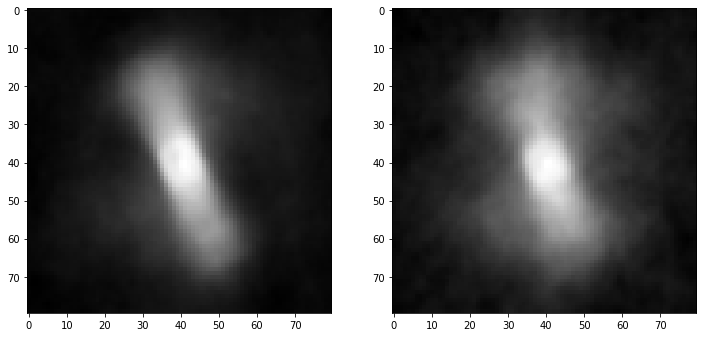

In [30]:
size = bnw[1,:,:].shape

fig, axs = plt.subplots(1, 2, figsize = [12, 12])

for i in np.arange(0, 2):
  sub = dat[vals.labels_ == i]
  img = np.mean(sub, axis = 0).reshape([80, 80])
  axs[i].imshow(img, cmap = 'gray')
        
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix

To make a better confusion matrix, we can use `pyplot`, which allows us to make tiled images to represent the number of cases in each quadrant and then annotate it. 

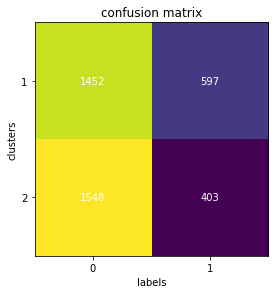

In [32]:
cm = confusion_matrix(vals.labels_, y)

fig, ax = plt.subplots()
im = ax.imshow(cm)

ax.set_xticks(np.arange(len(np.unique(vals.labels_))))
ax.set_yticks(np.arange(len(np.unique(y))))
ax.set_xticklabels(np.unique(vals.labels_))
ax.set_yticklabels(np.unique([1, 2]))

for i in range(len(np.unique(vals.labels_))):
    for j in range(len(np.unique(y))):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

ax.set_title("confusion matrix")
fig.tight_layout()

plt.xlabel('labels')
plt.ylabel('clusters')
plt.show()

In [33]:
print('Accuracy: ' + str(100 * np.sum(vals.labels_ == y) / y.shape[0]))
print('Accuracy: ' + str(100 * np.sum(vals.labels_ != y) / y.shape[0]))

Accuracy: 46.375
Accuracy: 53.625


#S6:
Split the data into train and test sets (50/50 split). Train a linear SVM with default parameters. Apply it on the test dataset.

- Q1: What is the training accuracy? **90.4**
- Q2: What is the testing accuracy? **85.8**
- Q3: What is the AUC? **0.93**

In [0]:
indPos = np.where(y == 1)[0]
indNeg = shuffle(np.where(y == 0)[0], random_state = 42)[0:indPos.shape[0]]

indBal = shuffle(np.concatenate([indPos, indNeg]), random_state = 42)

XBal = pcaCoor[indBal, :]
YBal = y[indBal]

scaler = preprocessing.StandardScaler().fit(XBal)
XBalSc = scaler.transform(XBal)

X_train, X_test, y_train, y_test = train_test_split(XBalSc, YBal, stratify = YBal, train_size = 0.5, random_state = 42)

In [35]:
print('Train size: ' + str(y_train.shape[0]))
svc = SVC(kernel = 'linear')

print('Training the model ...')
svc.fit(X_train, y_train)

print('Applying the model ...')
yPred_1 = svc.predict(X_train)
yPred_2 = svc.predict(X_test)

print('Training accuracy: ' + str(100 * np.sum(yPred_1 == y_train) / y_train.shape[0]))
print('Testing accuracy: ' + str(100 * np.sum(yPred_2 == y_test) / y_test.shape[0]))

Train size: 1000
Training the model ...
Applying the model ...
Training accuracy: 90.7
Testing accuracy: 85.7


In [0]:
from scipy import interp

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import StratifiedKFold

As in the last assignment, to get the area under the curve, we use cross-validation to check the robustness of the results. 

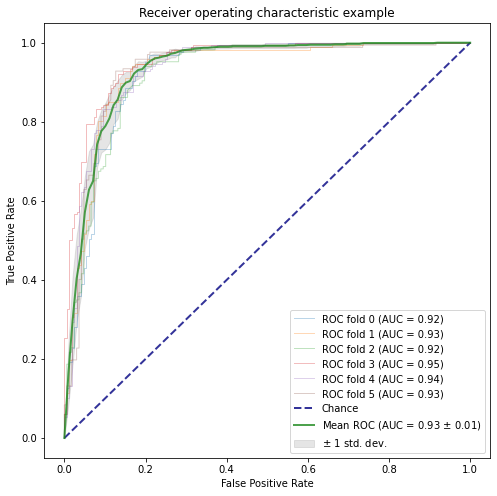

In [37]:
cv = StratifiedKFold(n_splits = 6)
classifier = SVC(kernel = 'linear', probability = True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X = XBalSc
y = YBal

fig, ax = plt.subplots(figsize = [8, 8])
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
        label='Chance', alpha= 0.8)

mean_tpr = np.mean(tprs, axis = 0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color = 'forestgreen',
        label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw = 2, alpha = 0.8)

std_tpr = np.std(tprs, axis = 0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'grey', alpha = 0.2,
                label = r'$\pm$ 1 std. dev.')

ax.set(xlim = [-0.05, 1.05], ylim = [-0.05, 1.05],
       title = "Receiver operating characteristic example")
ax.legend(loc = "lower right")
plt.show()

#S7:
Train "your best classifier". You can use parameter optimization, different classifiers, feature dimensionality reduction, or any other processing step for feature extraction on the data.

- Q1: What is the 10-fold testing accuracy of your classifier? **0.99**

**The parameter optimization steps we learned in class were a little much for my humble laptop, so I ended up trying to identify the optimal number of components. This loop runs through and tests out a bunch, saving the number the performed best when used in a simple linear SVC. It looks like it is possible to overfit and underfit with PCA: too few components do poorly—but also too many. The testing accuracy is almost identical for 40 and 80 components and 90 components does worse than 40. We select the best, 60 components, and use that reduced dataset with an RBF kernel, achieving a 96.8% testing accuracy.**

In [0]:
y = np.asarray(shipsnet['labels'])
X = np.asarray(shipsnet['data']).astype('uint8')

To start, we determine the ideal number of components. To do this, we start by setting the iterations—increments of 10—and then add some empty variables to store the data as we loop through. The code then we loop through a perform PCA and then an SVM classification with the number of components from that iteration. The loop prints the results and stores them. It also keeps the highest performer by using an `if` statement to see if the accuracy is better than 0, and then better than the one stored replacing that 0 from then on. 

In [62]:
COMP_TEST = [10, 20, 30, 40, 50, 60, 70, 80, 90]

training = []
testing = []

ACCURACY = 0

for i in np.arange(0, len(COMP_TEST)):
  NUM_COMP = COMP_TEST[i]
  pca = PCA(n_components = NUM_COMP)
  pcaMdl = pca.fit(X)
  pcaCoor = pcaMdl.transform(X)

  indPos = np.where(y == 1)[0]
  indNeg = shuffle(np.where(y == 0)[0], random_state = 42)[0:indPos.shape[0]]

  indBal = shuffle(np.concatenate([indPos, indNeg]), random_state = 42)

  XBal = pcaCoor[indBal, :]
  YBal = y[indBal]

  scaler = preprocessing.StandardScaler().fit(XBal)
  XBalSc = scaler.transform(XBal)

  X_train, X_test, y_train, y_test = train_test_split(XBalSc, YBal, stratify = YBal, train_size = 0.5, random_state = 42)

  svc = SVC(kernel = 'linear')
  svc.fit(X_train, y_train)

  yPred_1 = svc.predict(X_train)
  yPred_2 = svc.predict(X_test)

  training.append(100 * np.sum(yPred_1 == y_train) / y_train.shape[0])
  testing.append(100 * np.sum(yPred_2 == y_test) / y_test.shape[0])
  
  if 100 * np.sum(yPred_2 == y_test) / y_test.shape[0] > ACCURACY:
    ACCURACY = 100 * np.sum(yPred_2 == y_test) / y_test.shape[0]

    BEST = NUM_COMP

  print('Round {} | Training: '.format(i) + str(100 * np.sum(yPred_1 == y_train) / y_train.shape[0]) + ' | Testing:' + str(100 * np.sum(yPred_2 == y_test) / y_test.shape[0]))

Round 0 | Training: 83.1 | Testing:81.5
Round 1 | Training: 88.2 | Testing:86.2
Round 2 | Training: 90.1 | Testing:87.4
Round 3 | Training: 91.7 | Testing:88.1
Round 4 | Training: 92.3 | Testing:88.7
Round 5 | Training: 94.9 | Testing:89.8
Round 6 | Training: 94.7 | Testing:89.6
Round 7 | Training: 95.5 | Testing:88.0
Round 8 | Training: 95.9 | Testing:88.5


In a result interesting proof of overfitting, we can see that more components yields better *train* but, past a certain point, worse *testing*. 

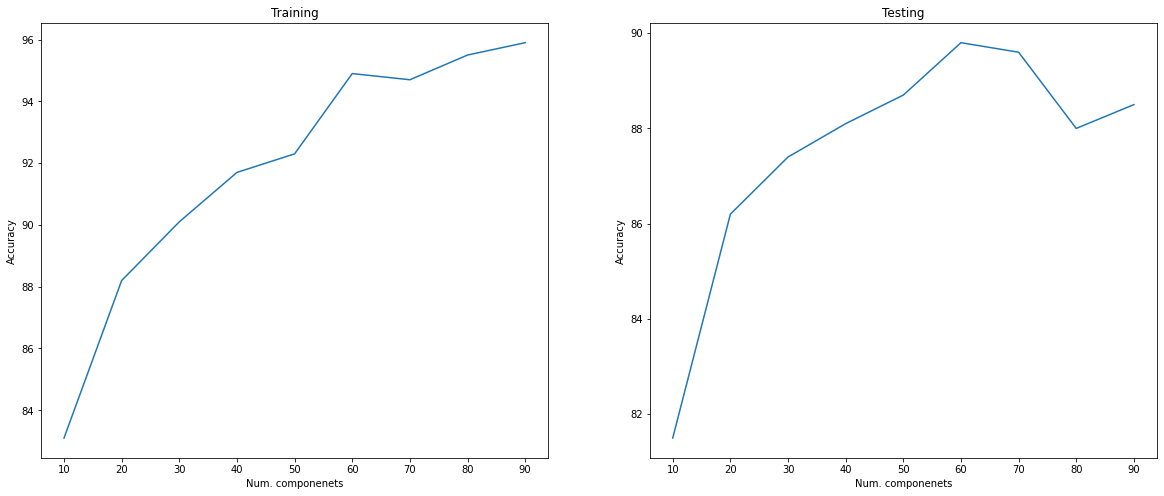

In [67]:
fig, axs = plt.subplots(1, 2, figsize = [20, 8])

axs[0].plot(COMP_TEST, training)
axs[0].set_title('Training')
axs[1].plot(COMP_TEST, testing)
axs[1].set_title('Testing')

for ax in axs.flat:
    ax.set(xlabel='Num. componenets', ylabel='Accuracy')

plt.show()

We can then just check manually which PCA iteration performed best, but it is stored as a variable regardless. 

In [50]:
print(BEST)

60


In [0]:
pca = PCA(n_components = BEST)
pcaMdl = pca.fit(X)
pcaCoor = pcaMdl.transform(X)

In [0]:
from sklearn.model_selection import GridSearchCV

Nested cross-validation was quite slow so it became impossible run upon opening the notebook; instead, after discovering that an RBF kernel performed best, we can add that manually and achieve a decent classification rate. The same code as beform also allows us to see the area under the curve, which is high—perhaps because it is training on such a large portion of the data.

In [43]:
indPos = np.where(y == 1)[0]
indNeg = shuffle(np.where(y == 0)[0], random_state = 42)[0:indPos.shape[0]]

indBal = shuffle(np.concatenate([indPos, indNeg]), random_state = 42)

XBal = pcaCoor[indBal, :]
YBal = y[indBal]

scaler = preprocessing.StandardScaler().fit(XBal)
XBalSc = scaler.transform(XBal)

X_train, X_test, y_train, y_test = train_test_split(XBalSc, YBal, stratify = YBal, train_size = 0.5, random_state = 42)

print('Train size: ' + str(y_train.shape[0]))
svc = SVC(kernel = 'rbf')

print('Training the model ...')
svc.fit(X_train, y_train)

print('Applying the model ...')
yPred_1 = svc.predict(X_train)
yPred_2 = svc.predict(X_test)

print('Training accuracy: ' + str(100 * np.sum(yPred_1 == y_train) / y_train.shape[0]))
print('Testing accuracy: ' + str(100 * np.sum(yPred_2 == y_test) / y_test.shape[0]))

Train size: 1000
Training the model ...
Applying the model ...
Training accuracy: 99.0
Testing accuracy: 96.8


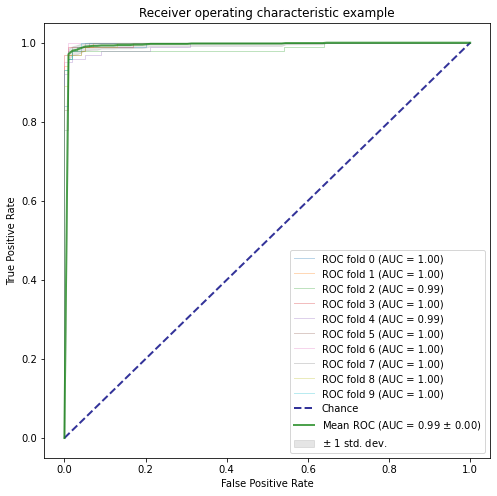

In [44]:
cv = StratifiedKFold(n_splits = 10)
classifier = SVC(kernel = 'rbf', probability = True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X = XBalSc
y = YBal

fig, ax = plt.subplots(figsize = [8, 8])
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
        label='Chance', alpha= 0.8)

mean_tpr = np.mean(tprs, axis = 0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color = 'forestgreen',
        label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw = 2, alpha = 0.8)

std_tpr = np.std(tprs, axis = 0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'grey', alpha = 0.2,
                label = r'$\pm$ 1 std. dev.')

ax.set(xlim = [-0.05, 1.05], ylim = [-0.05, 1.05],
       title = "Receiver operating characteristic example")
ax.legend(loc = "lower right")
plt.show()